In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import pickle

from pathlib import Path

import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display

from procyon.data.data_utils import DATA_DIR

# Load and reformat embeddings

In [3]:
# The following text embeddings were generated with OpenAI's text-embedding-3-small embedding model.
# The maximum input length is 8192 tokens (roughly 32k characters), texts that were longer than that
# were truncated (although this is a very small number of texts).
data_dir = Path(DATA_DIR) / "experimental_data" / "phenotype_embeddings"
tens_path =  data_dir / "parsed_embeds.pt"
idx_path =  data_dir / "embed_indices.tsv.gz"

reparse = False
if reparse:
    orig_path = "/n/home08/rcalef/sandbox/projects/txplm/rebuttal/text_embeddings/embeddings_output.jsonl"
    embeds = pd.read_json(orig_path, lines=True)
    display(embeds.head())

    embeds_tens = torch.tensor(np.stack(embeds.embedding.values), dtype=torch.float32)
    print(embeds_tens.shape)

    torch.save(embeds_tens, tens_path)

    embed_indices= (
        embeds
        .drop(columns=["embedding"])
        .assign(
            unique_id=lambda x: x.dataset + "_" + x.dataset_idx.astype(str),
        )
        .rename_axis(index="embed_idx")
        .reset_index()
    )
    display(embed_indices.head())
    embed_indices.to_csv(idx_path, sep="\t", index=False)

else:
    embeds_tens = torch.load(tens_path)
    embed_indices = pd.read_table(idx_path)

    print(embeds_tens.shape)
    display(embed_indices.head())

torch.Size([74348, 1536])


,embed_idx,text_id,dataset_idx,dataset,text_col,token_count,unique_id
0,0,DB00001,0,drugbank,moa,176,drugbank_0
1,1,DB00002,1,drugbank,moa,539,drugbank_1
2,2,DB00004,2,drugbank,moa,59,drugbank_2
3,3,DB00005,3,drugbank,moa,182,drugbank_3
4,4,DB00006,4,drugbank,moa,114,drugbank_4


In [4]:
# Note that this is a fairly large tensor (73k X 73k) so needs ~20GB of RAM to keep in memory
all_pairwise_sims = embeds_tens @ embeds_tens.T
all_pairwise_sims.shape

torch.Size([74348, 74348])

# Retrieval performance by train set similarity

For each zero-shot term:
- Get similarities to all train terms
- Take max similarity
- Bin by similarity score
- Plot performance

In [5]:
from procyon.data.constants import CANONICAL_SPLITS, RETRIEVAL_SUBSETS
from procyon.data.data_utils import DATA_DIR

data_path = os.path.join(
    DATA_DIR,
    "integrated_data",
    "v1",
)

all_datasets = [
    ("domain", "go"),
    ("domain", "pfam"),
    ("protein", "disgenet"),
    ("protein", "drugbank"),
    ("protein", "ec"),
    ("protein", "go"),
    ("protein", "gtop"),
    ("protein", "omim"),
    ("protein", "reactome"),
    ("protein", "uniprot"),
]

test_datasets = [
    x for x in all_datasets if x[1] not in ["uniprot", "gtop"]
]

def load_rels(aaseq_type: str, name: str) -> pd.DataFrame:
    """Get phenotype-protein relations for a given dataset"""
    split_name = CANONICAL_SPLITS[name]
    rels_path = os.path.join(
        data_path,
        f"{aaseq_type}_{name}",
        split_name,
        f"{aaseq_type}_{name}_relations_indexed.unified.csv"
    )
    return pd.read_csv(rels_path)


def get_train_relations():
    """Get training relations for all datasets

    Returns a DF with:
     - dataset_idx - numeric idx within the dataset
     - dataset - the dataset name
     - unique_id - concatenation of `dataset` and `dataset_idx`, unique identifier
                   across all datasets
     - seq_id - set containing the protein IDs related to this phenotype
     - count - number of proteins related to this phenotype, i.e. length of `seq_id`
    """
    all_rels = []
    for aaseq, dset in all_datasets:
        all_rels.append((
            load_rels(aaseq, dset)
            .query("split == 'CL_train'")
            .groupby("text_id")
            .seq_id
            .apply(set)
            .reset_index()
            .assign(dataset=dset, count=lambda x: x.apply(lambda y: len(y.seq_id), axis=1))
            .rename(columns={"text_id": "dataset_idx"})
        ))
    return pd.concat(all_rels).assign(unique_id=lambda x: x.dataset + "_" + x.dataset_idx.astype(str))

In [6]:
all_dfs = []
for aaseq, dataset in test_datasets:
    all_dfs.append((
        load_rels(aaseq, dataset)
        .loc[lambda x: x.split.str.contains("eval_zero_shot")]
        .drop_duplicates("text_id")
        .assign(dataset=dataset)
    ))
all_dfs = pd.concat(all_dfs)

In [7]:
len(all_dfs.text_id.drop_duplicates())

3031

In [8]:
all_dfs.head()

,text_type,seq_type,seq_id,text_id,relation,split,dataset,num_texts,Unnamed: 0,Phenotype Mapping Key
33888,Function,domain,607,399,21,eval_zero_shot,go,NaN,NaN,NaN
34437,Function,domain,607,1594,21,eval_zero_shot_hard,go,NaN,NaN,NaN
34455,Function,domain,12955,929,21,eval_zero_shot_hard,go,NaN,NaN,NaN
34472,Function,domain,12955,1691,21,eval_zero_shot_hard,go,NaN,NaN,NaN
34489,Function,domain,12955,425,21,eval_zero_shot,go,NaN,NaN,NaN


In [9]:
all_dfs.split.value_counts()

split
eval_zero_shot_easy    1577
eval_zero_shot_hard    1394
eval_zero_shot          987
Name: count, dtype: int64

In [10]:
all_train_rels = get_train_relations()
print(all_train_rels.shape)
all_train_rels.head()

(42445, 5)


,dataset_idx,seq_id,dataset,count,unique_id
0,6,"{1096, 7450, 31771, 31596}",go,4,go_6
1,8,"{14049, 14050, 27459, 26628, 18886, 41465, 414...",go,8,go_8
2,9,"{14049, 14050, 27459, 26628, 26617}",go,5,go_9
3,18,"{30412, 30413, 30414, 30415, 9237, 9753, 4479}",go,7,go_18
4,19,"{30412, 30413, 30414, 30415}",go,4,go_19


In [11]:
# Make lookup of unique_id -> set of related proteins
train_seq_lookup = (
    all_train_rels
    [["unique_id", "seq_id"]]
    .set_index("unique_id")
    .seq_id
    .to_dict()
)

In [12]:
# Get indices of training samples within the large
# phenotype embedding tensor
train_rows = (
    embed_indices
    .merge(all_train_rels[["unique_id", "count"]], on="unique_id")
)
print(train_rows.shape)
display(train_rows.head())

train_indices = train_rows["embed_idx"].to_numpy()
len(train_indices)

(61695, 8)


,embed_idx,text_id,dataset_idx,dataset,text_col,token_count,unique_id,count
0,1,DB00002,1,drugbank,moa,539,drugbank_1,3
1,2,DB00004,2,drugbank,moa,59,drugbank_2,2
2,3,DB00005,3,drugbank,moa,182,drugbank_3,7
3,5,DB00007,5,drugbank,moa,244,drugbank_5,1
4,6,DB00008,6,drugbank,moa,82,drugbank_6,2


61695

In [58]:
def perf_by_sim_df(
    aaseq: str,
    dataset: str,
    k: int = 1,
    cross_database_only: bool = False,
    sims_only: bool = False
) -> pd.DataFrame:
    """Get big dataframe of *zero-shot* phenotype retrieval performance grouped by embedding similarity to training phenotypes

    Params:
      - aaseq: amino acid sequence type (i.e. protein or domain)
      - dataset: name of dataset
      - k: number of top training phenotypes to consider, i.e. k=1 just looks at the single training phenotype
           with the highest similarity to the given phenotype, k=5 takes averages over the top 5 most similar
      - cross_database_only: if True, only consider training phenotypes from other databases
      - sims_only: if True, don't merge in retrieval results
    Returns:
      DataFrame with the following columns:
      - query_id: Numeric ID of phenotype within dataset (prob not useful)
      - query_db_id: Text ID of phenotype from dataset (e.g. GO:00001234)
      - max_train_sim: Average embedding similarity to top-k most similar train phenotypes
      - max_train_sim_count: Average number of proteins annotated to the top-k most similar train phenotypes
      - num_matched_seqs: Number of the top-k most similar train phenotypes that are annotated to one of the same
                          proteins as the considered eval phenotype
      - matched_text_count: For the subset of top-k hits with a matched seq (see above), how many proteins are
                            they annotated to, i.e. how many times do they show up in training
      Remaining columns come directly from the retrieval performance results
    """
    rels = (
        load_rels(aaseq, dataset)
        .loc[lambda x: x.split.str.contains("eval_zero_shot")]
        .assign(
            unique_id=lambda x: f"{dataset}_" + x.text_id.astype(str),
        )
    )

    zero_shot_texts = (
        rels
        .drop_duplicates("unique_id")
    )
    seqs_per_text = (
        rels
        .groupby("unique_id")
        .seq_id
        .apply(set)
        .to_dict()
    )
    print(f"{dataset}: got {len(zero_shot_texts)} zero shot texts")
    zero_shot_rows = (
        embed_indices
        .loc[lambda x: x.unique_id.isin(zero_shot_texts.unique_id)]
    )
    print(f"{dataset}: got {len(zero_shot_rows)} / {len(zero_shot_texts)} zero shot texts have embeddings")
    zero_shot_indices = zero_shot_rows.index.to_numpy()

    if cross_database_only:
        want_rows = (
            embed_indices
            .reset_index()
            .merge(all_train_rels[["unique_id", "count"]], on="unique_id")
            .loc[lambda x: x.dataset != dataset]
        )
    else:
        want_rows = train_rows

    counts = want_rows["count"].to_numpy()
    want_indices = want_rows["embed_idx"].to_numpy()
    print(f"{dataset}: taking max similarity over {len(want_indices)} train examples")

    max_sim = all_pairwise_sims[zero_shot_indices][:, want_indices].topk(k=k, dim=1)
    num_matched = []
    matched_counts = []
    for i, (_, row) in enumerate(zero_shot_rows.iterrows()):
        seqs = seqs_per_text[row.unique_id]
        topk_idxs = max_sim.indices[i].numpy()

        num_hits = 0
        match_count = 0
        for idx in topk_idxs:
            row = want_rows.iloc[idx]
            if any(map(lambda x: x in seqs, train_seq_lookup[row.unique_id])):
                num_hits += 1
                match_count += row["count"]
        num_matched.append(num_hits)
        matched_counts.append(match_count)


    train_set_sims = pd.DataFrame({
        "query_id": zero_shot_rows.dataset_idx,
        "query_db_id": zero_shot_rows.text_id,
        "query_text_col": zero_shot_rows.text_col,
        "max_train_sim": max_sim.values.mean(dim=1),
        "max_train_sim_count": counts[max_sim.indices.numpy()].mean(axis=1),
        "num_matched_seqs": num_matched,
        "matched_text_count": matched_counts,
    })

    if not sims_only:
        base_path = "/n/home08/rcalef/sandbox/projects/txplm/canonical_evals/test_new_repo/retrieval/ProCyon"
        if dataset == "go":
            types = ['process', 'function', 'component']
        elif dataset == "drugbank":
            types = ["drug_carrier", "drug_enzyme", "drug_target"]
        else:
            types = ["all"]

        zero_shot_scores = []
        for type in types:
            scores = (pd.read_table(os.path.join(
                base_path,
                f"protein_{dataset}_{type}_eval_zero_shot",
                "per_text_metrics.tsv",
            ))
            .drop(columns=["sample_num"])
            .groupby("query_id")
            .mean()
            .reset_index()
            )
            zero_shot_scores.append(scores)
        zero_shot_scores = pd.concat(zero_shot_scores)

        train_set_sims = (
            train_set_sims
            .merge(zero_shot_scores, on="query_id")
        )
    return train_set_sims

dataset_title_map = {
    "go": "GO",
    "disgenet": "DisGeNET",
    "omim": "OMIM",
    "reactome": "Reactome",
    "drugbank": "DrugBank",
    "ec": "EC",
}

def perf_by_sim(
    aaseq: str,
    dataset: str,
    k: int = 1,
    cross_database_only: bool = False,
    ax = None,
):
    """Plot retrieval performance by train set similarity.

    Uses DF from above to construct the plot.
    """
    train_set_sims = perf_by_sim_df(aaseq, dataset, cross_database_only=cross_database_only, k=k)
    cutoffs = np.linspace(0, 1.0, 11)
    plot_data = (
        train_set_sims
        .assign(
            binned_sim=lambda x: pd.cut(x.max_train_sim, bins=cutoffs)
        )
    )
    counts = plot_data.binned_sim.value_counts().sort_index()[lambda x: x != 0]
    ax = sns.barplot(
        x="binned_sim",
        y="Fmax",
        data=plot_data,
        order=counts.index,
        edgecolor="black",
        ax=ax,
    )
    ax.bar_label(ax.containers[0], labels=counts, padding=3, fontsize=12, label_type="center")
    ax.tick_params(axis='x', labelsize=7)
    ax.set_xlabel("Maximum train set phenotype similarity")
    ax.set_ylabel("Retrieval $F_{\max}$")

    dataset_title = dataset_title_map[dataset]
    ax.set_title(f"{dataset_title} zero-shot retrieval performance")

    return plot_data

def perf_by_sim_split(
    aaseq: str,
    dataset: str,
    k: int = 1,
    cross_database_only: bool = False,
    legend: bool = True,
    textsize: float = 12,
    ax = None,
):
    """Plot retrieval performance by train set similarity.

    Same as above, but splits out zero-shot phenotypes where any of the top-k train set
    hits are annotated to one of the same proteins.
    """
    train_set_sims = perf_by_sim_df(aaseq, dataset, cross_database_only=cross_database_only, k=k)
    cutoffs = np.linspace(0, 1.0, 11)
    plot_data = (
        train_set_sims
        .assign(
            binned_sim=lambda x: pd.cut(x.max_train_sim, bins=cutoffs),
            matched_protein=lambda x: x.num_matched_seqs > 0,
        )
    )
    counts = plot_data.binned_sim.value_counts().sort_index()[lambda x: x != 0]
    ax = sns.barplot(
        x="binned_sim",
        y="Fmax",
        hue="matched_protein",
        data=plot_data,
        order=counts.index,
        dodge=True,
        edgecolor="black",
        ax=ax,
    )

    counts = plot_data.query("not matched_protein").binned_sim.value_counts().sort_index()[lambda x: x != 0]
    ax.bar_label(ax.containers[0], labels=counts, padding=3, fontsize=textsize, label_type="center")

    counts = plot_data.query("matched_protein").binned_sim.value_counts().sort_index()[lambda x: x != 0]
    ax.bar_label(ax.containers[1], labels=counts, padding=3, fontsize=textsize, label_type="center")
    ax.tick_params(axis='x', labelsize=7)
    ax.set_xlabel("Maximum train set phenotype similarity")
    ax.set_ylabel("Retrieval $F_{\max}$")

    dataset_title = dataset_title_map[dataset]
    ax.set_title(f"{dataset_title} zero-shot retrieval performance")
    if not legend:
        ax.legend_.remove()


    return plot_data

In [14]:
all_sim_dfs = []
len(test_datasets)
for aaseq, dataset in test_datasets:
    all_sim_dfs.append(
        perf_by_sim_df(aaseq, dataset, k=5, cross_database_only=True, sims_only=True)
        .assign(dataset=dataset)
    )
all_sim_dfs = (
    pd.concat(all_sim_dfs)
    # Some duplicates to Domain-GO and Protein-GO
    .drop_duplicates(["query_db_id", "query_text_col"])
)

print(all_sim_dfs.shape)
all_sim_dfs.head()

go: got 70 zero shot texts
go: got 70 / 70 zero shot texts have embeddings
go: taking max similarity over 57115 train examples
pfam: got 638 zero shot texts
pfam: got 1205 / 638 zero shot texts have embeddings
pfam: taking max similarity over 51747 train examples
disgenet: got 181 zero shot texts
disgenet: got 181 / 181 zero shot texts have embeddings
disgenet: taking max similarity over 54272 train examples
drugbank: got 523 zero shot texts
drugbank: got 1003 / 523 zero shot texts have embeddings
drugbank: taking max similarity over 57423 train examples
ec: got 704 zero shot texts
ec: got 704 / 704 zero shot texts have embeddings
ec: taking max similarity over 61280 train examples
go: got 274 zero shot texts
go: got 274 / 274 zero shot texts have embeddings
go: taking max similarity over 57115 train examples
omim: got 1310 zero shot texts
omim: got 5143 / 1310 zero shot texts have embeddings
omim: taking max similarity over 44975 train examples
reactome: got 258 zero shot texts
reacto

,query_id,query_db_id,query_text_col,max_train_sim,max_train_sim_count,num_matched_seqs,matched_text_count,dataset
7314,25,GO:0000152,go_def,0.624915,1.0,0,0,go
7637,360,GO:0004143,go_def,0.627025,1.6,0,0,go
7638,361,GO:0004175,go_def,0.611923,1.0,0,0,go
7640,363,GO:0004180,go_def,0.646375,1.0,0,0,go
7642,365,GO:0004190,go_def,0.612427,15.2,0,0,go


In [15]:
len(all_sim_dfs.query_db_id.unique())

3888

In [11]:
eval_sims_path =  data_dir / "eval_phenotype_sims.tsv.gz"
all_sim_dfs.to_csv(eval_sims_path, sep="\t", index=False)

## Max train set sim plots

In [53]:
save_path = Path("/n/home08/rcalef/sandbox/projects/txplm/rebuttal/figures")

In [32]:
def plot_all_datasets(
    split=False,
    k=1,
    cross_database_only=False,
    textsize=12,
):
    # Define the number of rows and columns for the grid
    nrows, ncols = 2, 3

    # Create a figure with subplots
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(15, 10), sharey=True
    )  # Adjust size as needed
    flat_axes = axes.flatten()  # Flatten to easily iterate

    all_data = []
    plot_idx = 0
    for aaseq, dataset in test_datasets:
        if dataset in ["uniprot", "gtop"] or aaseq == "domain":
            continue

        if split:
            legend = False
            if plot_idx == len(test_datasets) - 1:
                legend = True
            all_data.append(
                perf_by_sim_split(
                    aaseq,
                    dataset,
                    ax=flat_axes[plot_idx],
                    legend=legend,
                    k=k,
                    cross_database_only=cross_database_only,
                    textsize=textsize,
                ).assign(dataset=dataset)
            )
        else:
            all_data.append(
                perf_by_sim(
                    aaseq,
                    dataset,
                    ax=flat_axes[plot_idx],
                    k=k,
                    cross_database_only=cross_database_only,
                ).assign(dataset=dataset)
            )

        plot_idx += 1

    sns.despine()
    for row, row_axes in enumerate(axes):
        for col, ax in enumerate(row_axes):
            if col != 0:
                ax.yaxis.set_visible(False)
                ax.spines["left"].set_visible(False)

    return pd.concat(all_data, ignore_index=True)

### Including same database

disgenet: got 181 zero shot texts
disgenet: got 181 / 181 zero shot texts have embeddings
disgenet: taking max similarity over 61695 train examples
drugbank: got 523 zero shot texts
drugbank: got 1003 / 523 zero shot texts have embeddings
drugbank: taking max similarity over 61695 train examples
ec: got 704 zero shot texts
ec: got 704 / 704 zero shot texts have embeddings
ec: taking max similarity over 61695 train examples
go: got 274 zero shot texts
go: got 274 / 274 zero shot texts have embeddings
go: taking max similarity over 61695 train examples
omim: got 1310 zero shot texts
omim: got 5143 / 1310 zero shot texts have embeddings
omim: taking max similarity over 61695 train examples
reactome: got 258 zero shot texts
reactome: got 258 / 258 zero shot texts have embeddings
reactome: taking max similarity over 61695 train examples


,query_id,query_db_id,query_text_col,max_train_sim,max_train_sim_count,num_matched_seqs,matched_text_count,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,binned_sim
0,478,C0001733,description_all_collapse,0.690421,4.0,1,4,0.30,1.000000,0.150000,1.000000,0.090909,1.0,0.535684,0.897778,0.503016,"(0.6, 0.7]"
1,846,C0002726,description_all_collapse,0.648322,63.0,1,63,0.22,0.366667,0.200000,0.666667,0.090909,1.0,0.360714,0.655278,0.225902,"(0.6, 0.7]"
2,3216,C0008533,description_all_collapse,0.838882,1.0,1,1,0.10,1.000000,0.090909,1.000000,0.090909,1.0,1.000000,1.000000,1.000000,"(0.8, 0.9]"
3,4549,C0011993,description_all_collapse,0.675828,1.0,0,0,0.20,1.000000,0.100000,1.000000,0.090909,1.0,0.480000,0.772500,0.358413,"(0.6, 0.7]"
4,4989,C0013264,description_all_collapse,0.726675,1.0,0,0,0.10,0.333333,0.100000,0.666667,0.090909,1.0,0.253534,0.547778,0.149727,"(0.7, 0.8]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4047,2437,R-HSA-1299316,description,0.557070,1.0,0,0,0.14,0.700000,0.100000,1.000000,NaN,NaN,0.310897,0.585000,0.163532,"(0.5, 0.6]"
4048,2441,R-HSA-1296061,description,0.740310,1.0,0,0,0.40,1.000000,0.200000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,"(0.7, 0.8]"
4049,2488,R-HSA-5627083,description,0.800859,44.0,1,44,0.30,1.000000,0.150000,1.000000,NaN,NaN,0.633333,0.924444,0.541905,"(0.8, 0.9]"
4050,2518,R-HSA-2473224,description,0.659339,12.0,1,12,0.40,1.000000,0.200000,1.000000,NaN,NaN,0.871111,0.978750,0.785833,"(0.6, 0.7]"


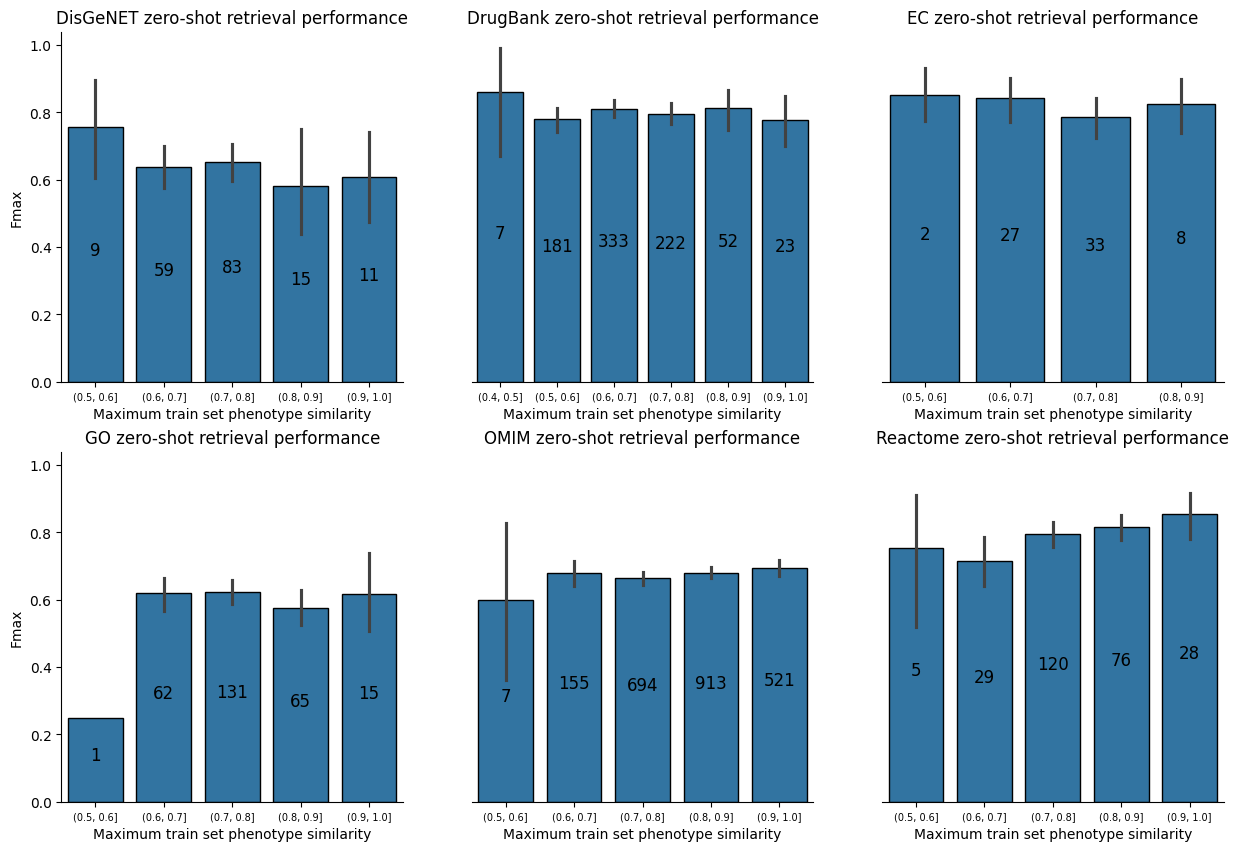

In [56]:
plot_all_datasets()

disgenet: got 181 zero shot texts
disgenet: got 181 / 181 zero shot texts have embeddings
disgenet: taking max similarity over 61695 train examples
drugbank: got 523 zero shot texts
drugbank: got 1003 / 523 zero shot texts have embeddings
drugbank: taking max similarity over 61695 train examples
ec: got 704 zero shot texts
ec: got 704 / 704 zero shot texts have embeddings
ec: taking max similarity over 61695 train examples
go: got 274 zero shot texts
go: got 274 / 274 zero shot texts have embeddings
go: taking max similarity over 61695 train examples
omim: got 1310 zero shot texts
omim: got 5143 / 1310 zero shot texts have embeddings
omim: taking max similarity over 61695 train examples
reactome: got 258 zero shot texts
reactome: got 258 / 258 zero shot texts have embeddings
reactome: taking max similarity over 61695 train examples


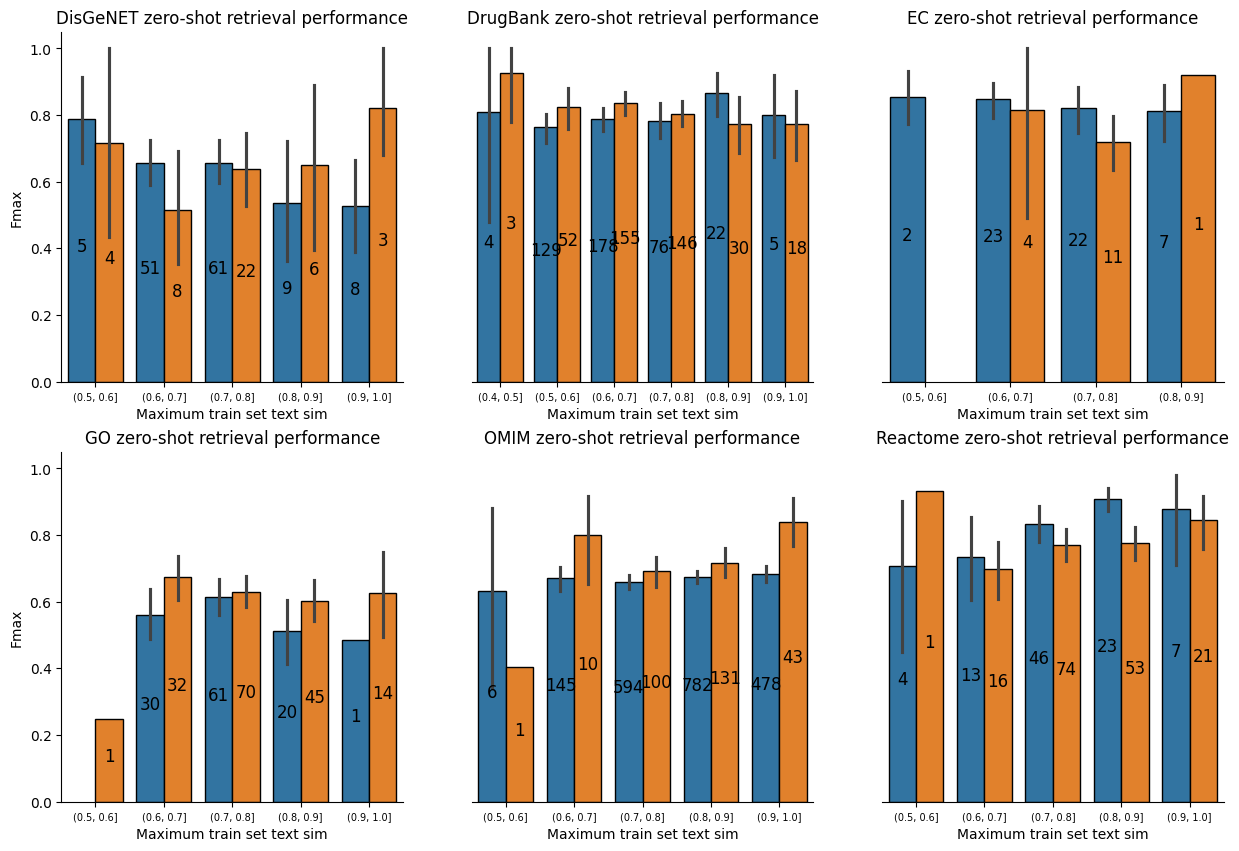

In [48]:
all_data = plot_all_datasets(split=True)

Text(0.5, 1.0, 'All datasets zero shot retrieval performance')

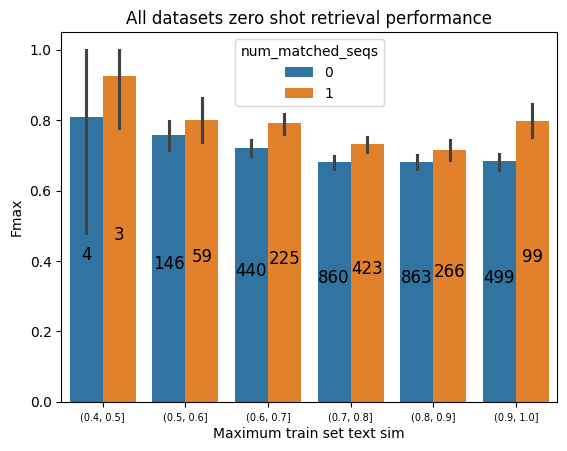

In [49]:
counts = all_data.binned_sim.value_counts().sort_index()[lambda x: x != 0]

ax = sns.barplot(x="binned_sim", y="Fmax", hue="num_matched_seqs", data=all_data, order=counts.index)
counts = all_data.query("num_matched_seqs == 0").binned_sim.value_counts().sort_index()[lambda x: x != 0]
ax.bar_label(ax.containers[0], labels=counts, padding=3, fontsize=12, label_type="center")

counts = all_data.query("num_matched_seqs == 1").binned_sim.value_counts().sort_index()[lambda x: x != 0]
ax.bar_label(ax.containers[1], labels=counts, padding=3, fontsize=12, label_type="center")

ax.tick_params(axis='x', labelsize=7)
ax.set_xlabel("Maximum train set text sim")
ax.set_title(f"All datasets zero shot retrieval performance")

disgenet: got 181 zero shot texts
disgenet: got 181 / 181 zero shot texts have embeddings
disgenet: taking max similarity over 61695 train examples
drugbank: got 523 zero shot texts
drugbank: got 1003 / 523 zero shot texts have embeddings
drugbank: taking max similarity over 61695 train examples
ec: got 704 zero shot texts
ec: got 704 / 704 zero shot texts have embeddings
ec: taking max similarity over 61695 train examples
go: got 274 zero shot texts
go: got 274 / 274 zero shot texts have embeddings
go: taking max similarity over 61695 train examples
omim: got 1310 zero shot texts
omim: got 5143 / 1310 zero shot texts have embeddings
omim: taking max similarity over 61695 train examples
reactome: got 258 zero shot texts
reactome: got 258 / 258 zero shot texts have embeddings
reactome: taking max similarity over 61695 train examples


,query_id,query_db_id,query_text_col,max_train_sim,max_train_sim_count,num_matched_seqs,matched_text_count,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,binned_sim
0,478,C0001733,description_all_collapse,0.667740,1.6,1,4,0.30,1.000000,0.150000,1.000000,0.090909,1.0,0.535684,0.897778,0.503016,"(0.6, 0.7]"
1,846,C0002726,description_all_collapse,0.618452,13.6,1,63,0.22,0.366667,0.200000,0.666667,0.090909,1.0,0.360714,0.655278,0.225902,"(0.6, 0.7]"
2,3216,C0008533,description_all_collapse,0.743944,1.6,3,3,0.10,1.000000,0.090909,1.000000,0.090909,1.0,1.000000,1.000000,1.000000,"(0.7, 0.8]"
3,4549,C0011993,description_all_collapse,0.626792,5.4,1,3,0.20,1.000000,0.100000,1.000000,0.090909,1.0,0.480000,0.772500,0.358413,"(0.6, 0.7]"
4,4989,C0013264,description_all_collapse,0.694346,1.4,1,3,0.10,0.333333,0.100000,0.666667,0.090909,1.0,0.253534,0.547778,0.149727,"(0.6, 0.7]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4047,2437,R-HSA-1299316,description,0.528874,3.4,1,9,0.14,0.700000,0.100000,1.000000,NaN,NaN,0.310897,0.585000,0.163532,"(0.5, 0.6]"
4048,2441,R-HSA-1296061,description,0.717197,2.8,2,11,0.40,1.000000,0.200000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,"(0.7, 0.8]"
4049,2488,R-HSA-5627083,description,0.733641,29.0,1,44,0.30,1.000000,0.150000,1.000000,NaN,NaN,0.633333,0.924444,0.541905,"(0.7, 0.8]"
4050,2518,R-HSA-2473224,description,0.627430,3.4,2,13,0.40,1.000000,0.200000,1.000000,NaN,NaN,0.871111,0.978750,0.785833,"(0.6, 0.7]"


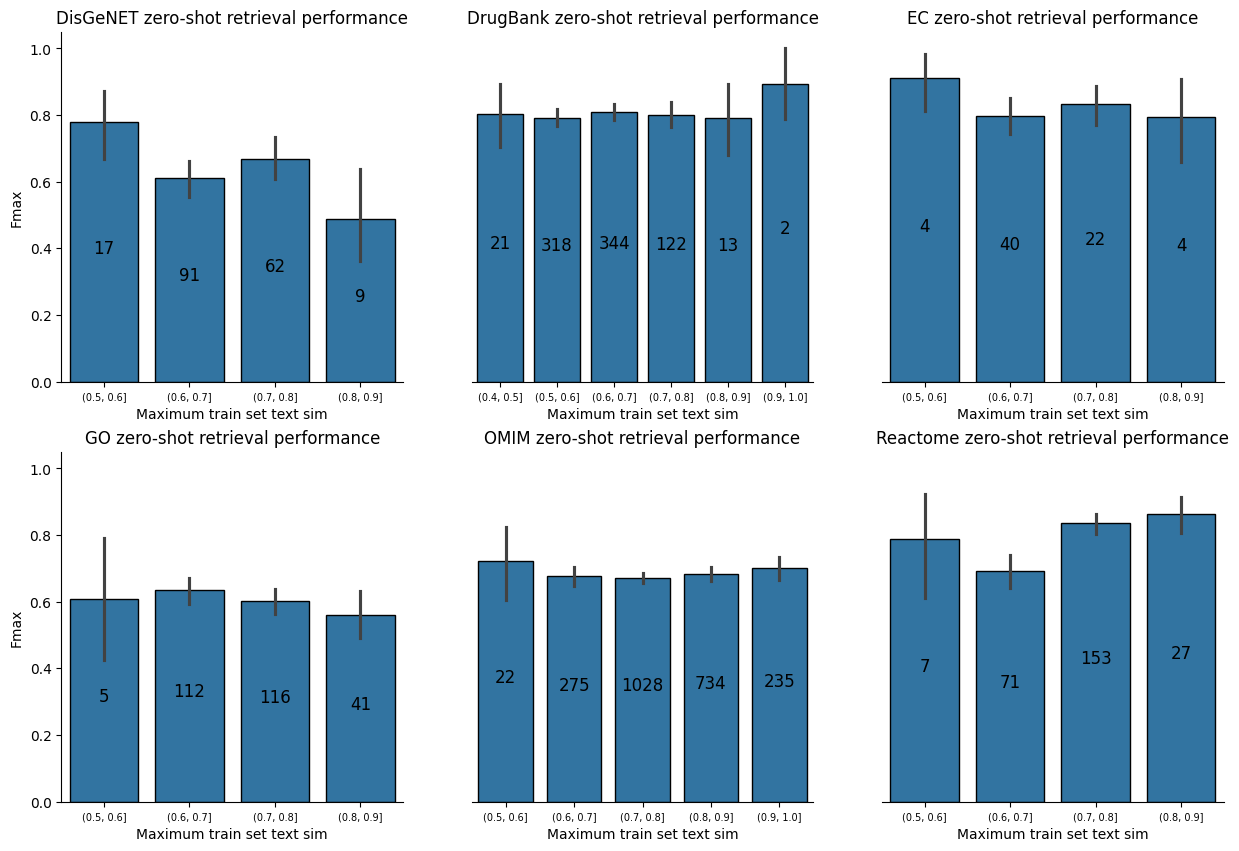

In [50]:
plot_all_datasets(split=False, k=5)

disgenet: got 181 zero shot texts
disgenet: got 181 / 181 zero shot texts have embeddings
disgenet: taking max similarity over 61695 train examples
drugbank: got 523 zero shot texts
drugbank: got 1003 / 523 zero shot texts have embeddings
drugbank: taking max similarity over 61695 train examples
ec: got 704 zero shot texts
ec: got 704 / 704 zero shot texts have embeddings
ec: taking max similarity over 61695 train examples
go: got 274 zero shot texts
go: got 274 / 274 zero shot texts have embeddings
go: taking max similarity over 61695 train examples
omim: got 1310 zero shot texts
omim: got 5143 / 1310 zero shot texts have embeddings
omim: taking max similarity over 61695 train examples
reactome: got 258 zero shot texts
reactome: got 258 / 258 zero shot texts have embeddings
reactome: taking max similarity over 61695 train examples


,query_id,query_db_id,query_text_col,max_train_sim,max_train_sim_count,num_matched_seqs,matched_text_count,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,binned_sim,matched_protein
0,478,C0001733,description_all_collapse,0.667740,1.6,1,4,0.30,1.000000,0.150000,1.000000,0.090909,1.0,0.535684,0.897778,0.503016,"(0.6, 0.7]",True
1,846,C0002726,description_all_collapse,0.618452,13.6,1,63,0.22,0.366667,0.200000,0.666667,0.090909,1.0,0.360714,0.655278,0.225902,"(0.6, 0.7]",True
2,3216,C0008533,description_all_collapse,0.743944,1.6,3,3,0.10,1.000000,0.090909,1.000000,0.090909,1.0,1.000000,1.000000,1.000000,"(0.7, 0.8]",True
3,4549,C0011993,description_all_collapse,0.626792,5.4,1,3,0.20,1.000000,0.100000,1.000000,0.090909,1.0,0.480000,0.772500,0.358413,"(0.6, 0.7]",True
4,4989,C0013264,description_all_collapse,0.694346,1.4,1,3,0.10,0.333333,0.100000,0.666667,0.090909,1.0,0.253534,0.547778,0.149727,"(0.6, 0.7]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4047,2437,R-HSA-1299316,description,0.528874,3.4,1,9,0.14,0.700000,0.100000,1.000000,NaN,NaN,0.310897,0.585000,0.163532,"(0.5, 0.6]",True
4048,2441,R-HSA-1296061,description,0.717197,2.8,2,11,0.40,1.000000,0.200000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,"(0.7, 0.8]",True
4049,2488,R-HSA-5627083,description,0.733641,29.0,1,44,0.30,1.000000,0.150000,1.000000,NaN,NaN,0.633333,0.924444,0.541905,"(0.7, 0.8]",True
4050,2518,R-HSA-2473224,description,0.627430,3.4,2,13,0.40,1.000000,0.200000,1.000000,NaN,NaN,0.871111,0.978750,0.785833,"(0.6, 0.7]",True


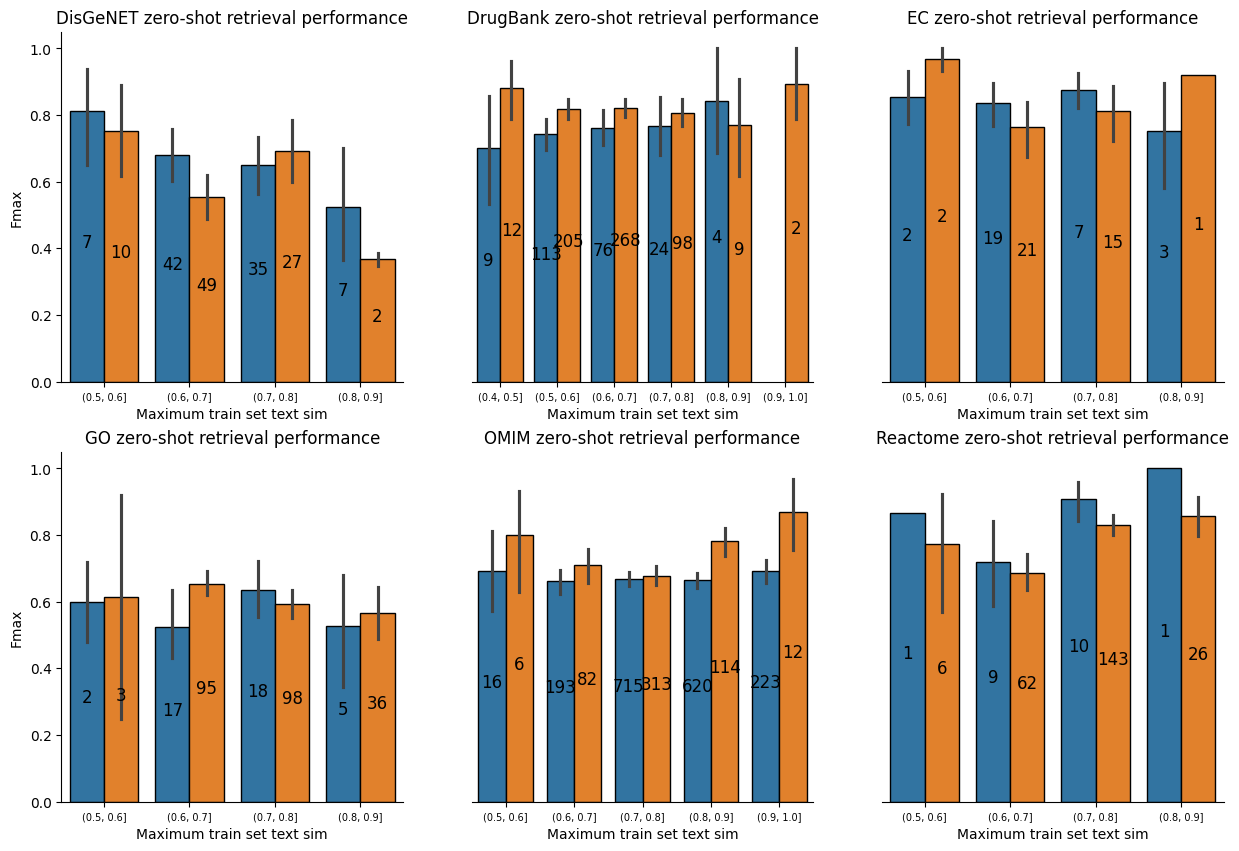

In [51]:
plot_all_datasets(k=5, split=True)

### Cross-database only

disgenet: got 181 zero shot texts
disgenet: got 181 / 181 zero shot texts have embeddings
disgenet: taking max similarity over 54272 train examples
drugbank: got 523 zero shot texts
drugbank: got 1003 / 523 zero shot texts have embeddings
drugbank: taking max similarity over 57423 train examples
ec: got 704 zero shot texts
ec: got 704 / 704 zero shot texts have embeddings
ec: taking max similarity over 61280 train examples
go: got 274 zero shot texts
go: got 274 / 274 zero shot texts have embeddings
go: taking max similarity over 57115 train examples
omim: got 1310 zero shot texts
omim: got 5143 / 1310 zero shot texts have embeddings
omim: taking max similarity over 44975 train examples
reactome: got 258 zero shot texts
reactome: got 258 / 258 zero shot texts have embeddings
reactome: taking max similarity over 59516 train examples


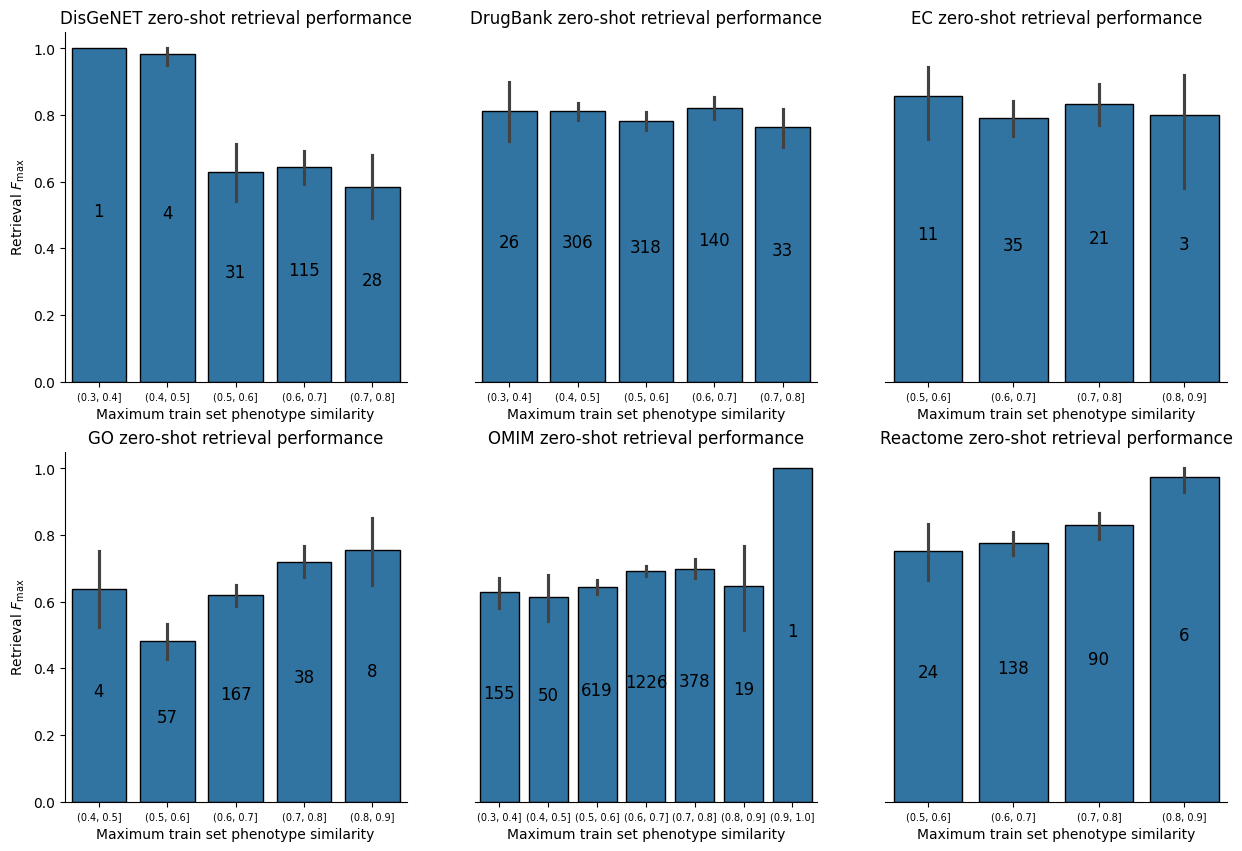

In [59]:
all_data = plot_all_datasets(split=False, k=5, cross_database_only=True)


plt.savefig(save_path / "retrieval_by_crossdb_sim_indiv_datasets.pdf", bbox_inches="tight")

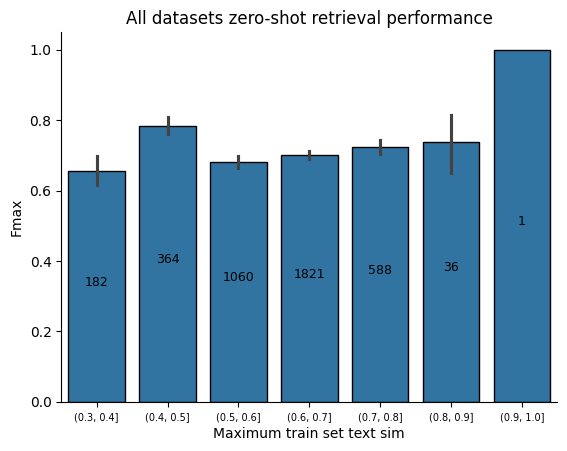

In [24]:
counts = all_data.binned_sim.value_counts().sort_index()[lambda x: x != 0]

ax = sns.barplot(x="binned_sim", y="Fmax", data=all_data, order=counts.index, edgecolor="black")
counts = all_data.binned_sim.value_counts().sort_index()[lambda x: x != 0]
ax.bar_label(ax.containers[0], labels=counts, padding=3, fontsize=9, label_type="center")

ax.tick_params(axis='x', labelsize=7)
ax.set_xlabel("Maximum train set text sim")
ax.set_title(f"All datasets zero-shot retrieval performance")
sns.despine()

In [30]:
all_data.query("dataset == 'omim'").sort_values("max_train_sim")

,query_id,query_db_id,query_text_col,max_train_sim,max_train_sim_count,num_matched_seqs,matched_text_count,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,binned_sim,dataset
2382,81,619113,omim_title_curated,0.351896,1.8,0,0,0.1,1.0,0.090909,1.0,NaN,NaN,0.480000,0.77,0.323333,"(0.3, 0.4]",omim
1372,336,300238,omim_def_curated,0.398986,2.8,0,0,0.1,1.0,0.090909,1.0,NaN,NaN,0.298254,0.50,0.176905,"(0.3, 0.4]",omim
1373,347,616887,omim_def_curated,0.398986,2.8,0,0,0.1,1.0,0.090909,1.0,NaN,NaN,0.430000,0.70,0.278571,"(0.3, 0.4]",omim
1521,1878,614152,omim_def_curated,0.398986,2.8,0,0,0.1,1.0,0.090909,1.0,NaN,NaN,0.262698,0.42,0.151905,"(0.3, 0.4]",omim
1587,2488,136120,omim_def_curated,0.399019,2.8,0,0,0.1,1.0,0.090909,1.0,NaN,NaN,0.933333,0.99,0.900000,"(0.3, 0.4]",omim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1580,2440,613390,omim_def_curated,0.840460,6.8,0,0,0.1,1.0,0.090909,1.0,NaN,NaN,0.301587,0.48,0.182143,"(0.8, 0.9]",omim
1581,2441,614083,omim_def_curated,0.840460,6.8,1,30,0.1,1.0,0.090909,1.0,NaN,NaN,0.800000,0.94,0.700000,"(0.8, 0.9]",omim
1446,1167,608836,omim_def_curated,0.843584,1.0,4,4,0.1,1.0,0.090909,1.0,NaN,NaN,1.000000,1.00,1.000000,"(0.8, 0.9]",omim
1468,1390,618036,omim_def_curated,0.852311,1.0,0,0,0.1,1.0,0.090909,1.0,NaN,NaN,0.766667,0.92,0.666667,"(0.8, 0.9]",omim


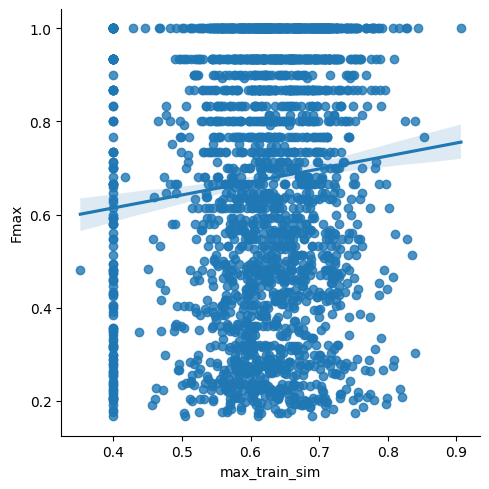

In [28]:
sns.lmplot(x="max_train_sim", y="Fmax", data=all_data.query("dataset =='omim'"))

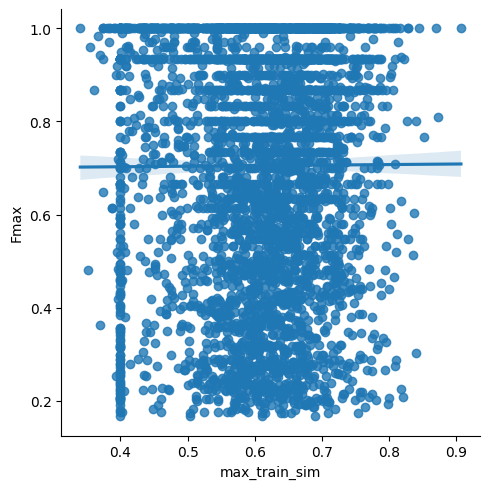

In [ ]:
sns.lmplot(x="max_train_sim", y="Fmax", data=all_data.query("dataset =='go'"))

disgenet: got 181 zero shot texts
disgenet: got 181 / 181 zero shot texts have embeddings
disgenet: taking max similarity over 54272 train examples
drugbank: got 523 zero shot texts
drugbank: got 1003 / 523 zero shot texts have embeddings
drugbank: taking max similarity over 57423 train examples
ec: got 704 zero shot texts
ec: got 704 / 704 zero shot texts have embeddings
ec: taking max similarity over 61280 train examples
go: got 274 zero shot texts
go: got 274 / 274 zero shot texts have embeddings
go: taking max similarity over 57115 train examples
omim: got 1310 zero shot texts
omim: got 5143 / 1310 zero shot texts have embeddings
omim: taking max similarity over 44975 train examples
reactome: got 258 zero shot texts
reactome: got 258 / 258 zero shot texts have embeddings
reactome: taking max similarity over 59516 train examples


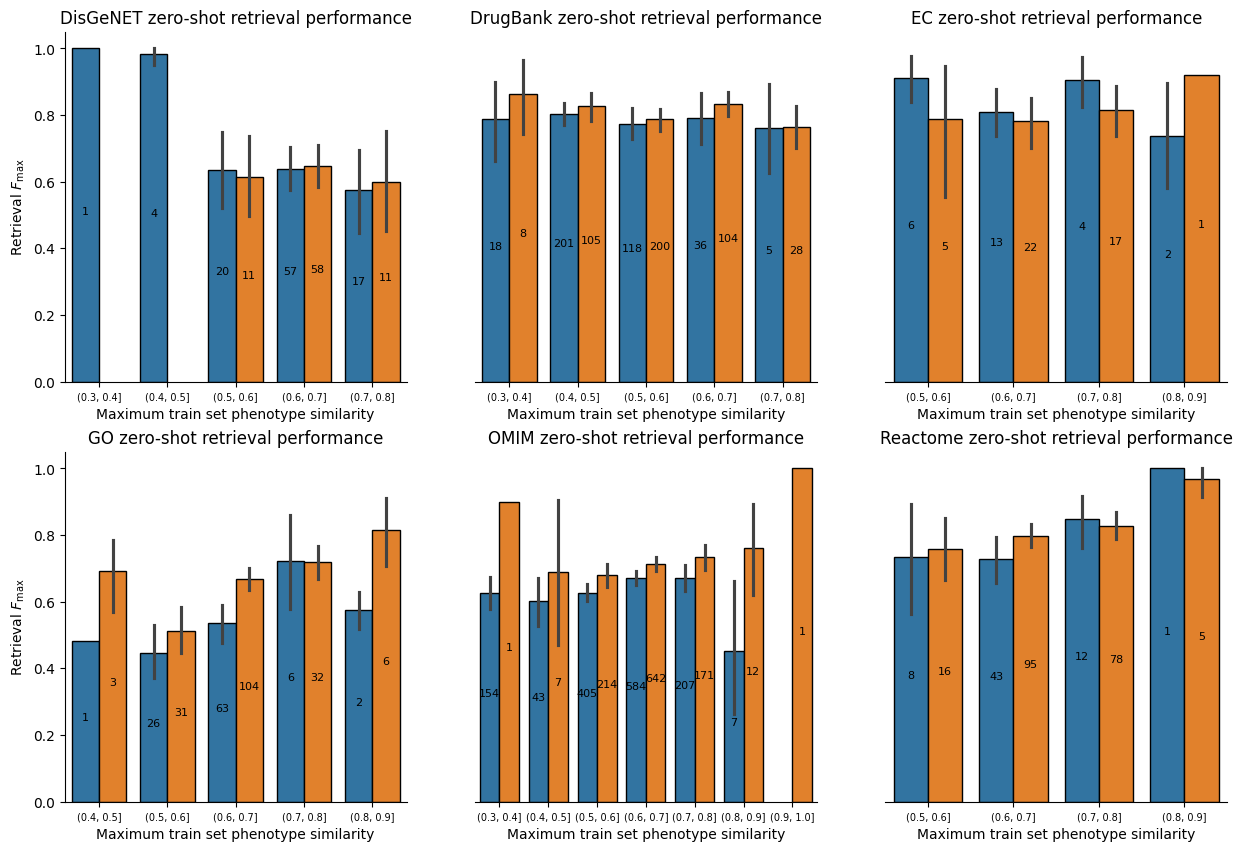

In [61]:
all_data = plot_all_datasets(split=True, k=5, cross_database_only=True, textsize=8)

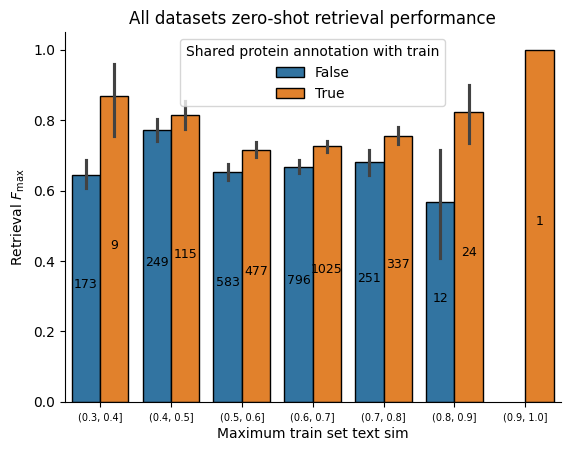

In [62]:
counts = all_data.binned_sim.value_counts().sort_index()[lambda x: x != 0]

ax = sns.barplot(x="binned_sim", y="Fmax", hue="matched_protein", data=all_data, order=counts.index, edgecolor="black")
counts = all_data.query("not matched_protein").binned_sim.value_counts().sort_index()[lambda x: x != 0]
ax.bar_label(ax.containers[0], labels=counts, padding=3, fontsize=9, label_type="center")

counts = all_data.query("matched_protein").binned_sim.value_counts().sort_index()[lambda x: x != 0]
ax.bar_label(ax.containers[1], labels=counts, padding=3, fontsize=9, label_type="center")

ax.tick_params(axis='x', labelsize=7)
ax.set_xlabel("Maximum train set text sim")
ax.set_ylabel("Retrieval $F_{\max}$")
ax.set_title(f"All datasets zero-shot retrieval performance")
plt.legend(title="Shared protein annotation with train")
sns.despine()

plt.savefig(save_path / "retrieval_by_crossdb_sim_all_datasets.split.pdf", bbox_inches="tight")

### Joint hex plots

Including same dataset

disgenet: got 181 zero shot texts
disgenet: got 181 / 181 zero shot texts have embeddings
disgenet: taking max similarity over 61695 train examples


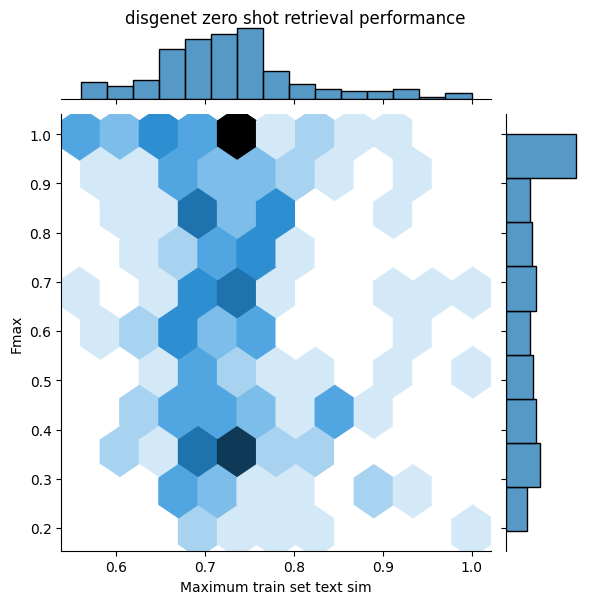

drugbank: got 523 zero shot texts
drugbank: got 1003 / 523 zero shot texts have embeddings
drugbank: taking max similarity over 61695 train examples


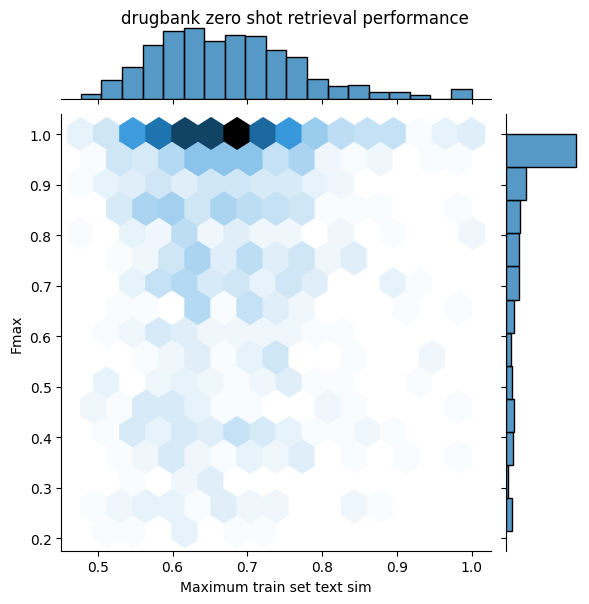

ec: got 704 zero shot texts
ec: got 704 / 704 zero shot texts have embeddings
ec: taking max similarity over 61695 train examples


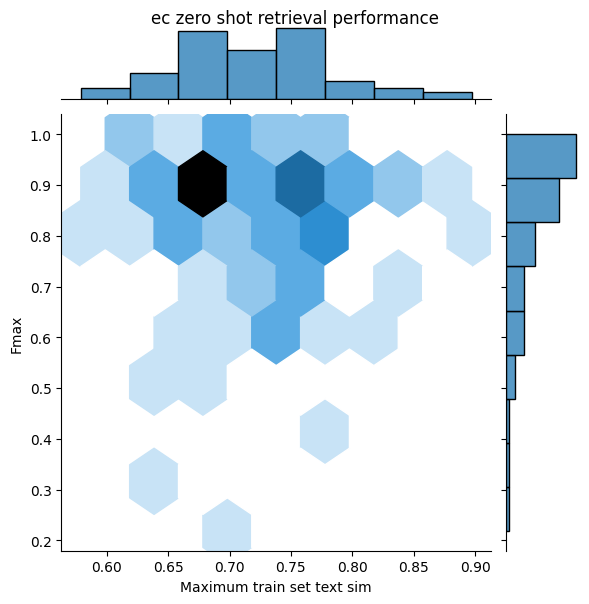

go: got 274 zero shot texts
go: got 274 / 274 zero shot texts have embeddings
go: taking max similarity over 61695 train examples


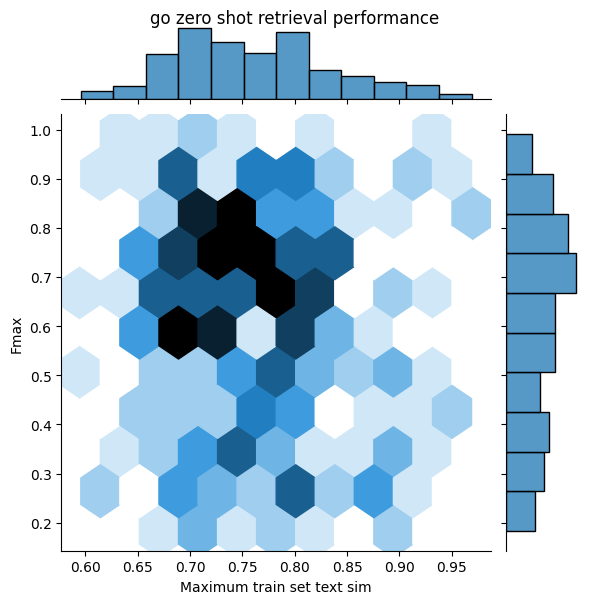

omim: got 1310 zero shot texts
omim: got 5143 / 1310 zero shot texts have embeddings
omim: taking max similarity over 61695 train examples


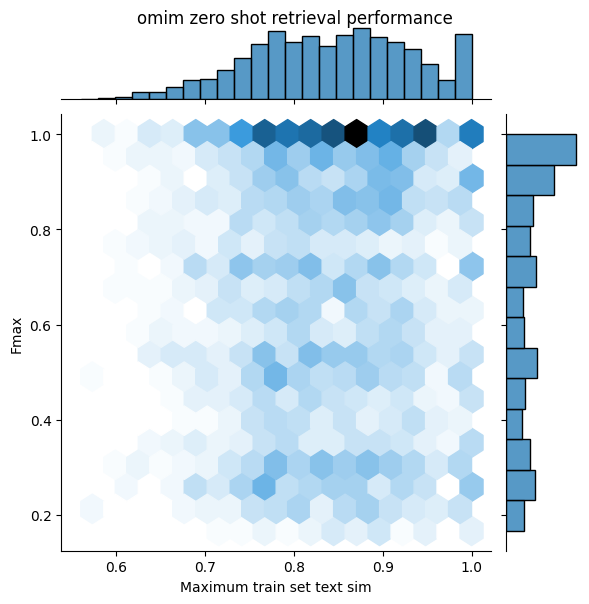

reactome: got 258 zero shot texts
reactome: got 258 / 258 zero shot texts have embeddings
reactome: taking max similarity over 61695 train examples


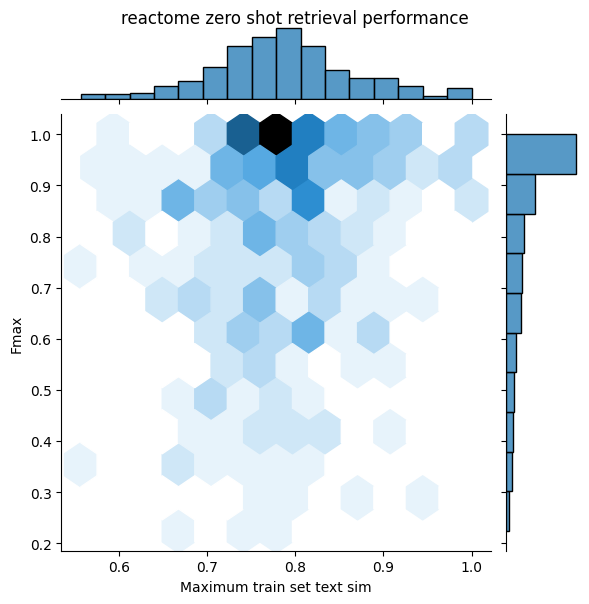

In [20]:
for aaseq, dataset in test_datasets:
    if dataset in ["uniprot", "gtop"] or aaseq == "domain":
        continue
    train_set_sims = perf_by_sim_df(aaseq, dataset, cross_database_only=False)
    ax = sns.jointplot(x="max_train_sim", y="Fmax", data=train_set_sims, kind="hex")
    ax.set_axis_labels(xlabel="Maximum train set text sim", ylabel="Fmax")
    ax.figure.suptitle(f"{dataset} zero shot retrieval performance", y=1.0)
    plt.show()

Cross-database only

disgenet: got 181 zero shot texts
disgenet: got 181 / 181 zero shot texts have embeddings
disgenet: taking max similarity over 54272 train examples


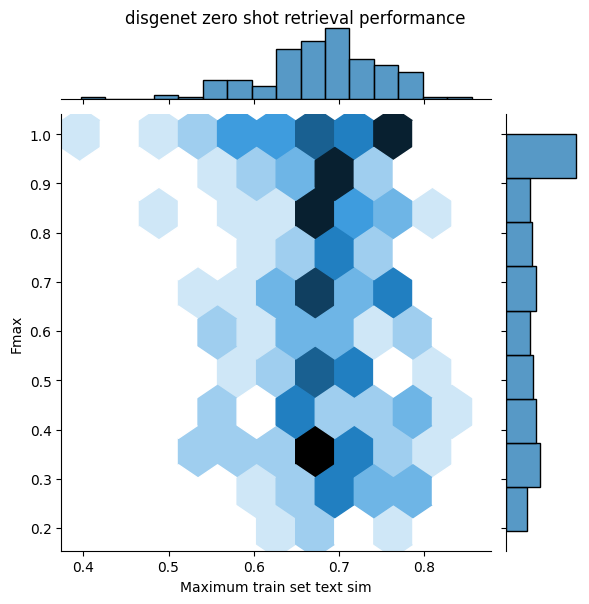

drugbank: got 523 zero shot texts
drugbank: got 1003 / 523 zero shot texts have embeddings
drugbank: taking max similarity over 57423 train examples


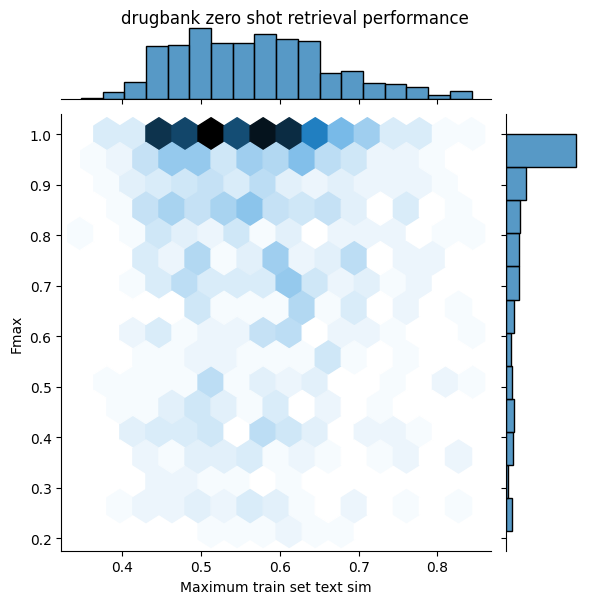

ec: got 704 zero shot texts
ec: got 704 / 704 zero shot texts have embeddings
ec: taking max similarity over 61280 train examples


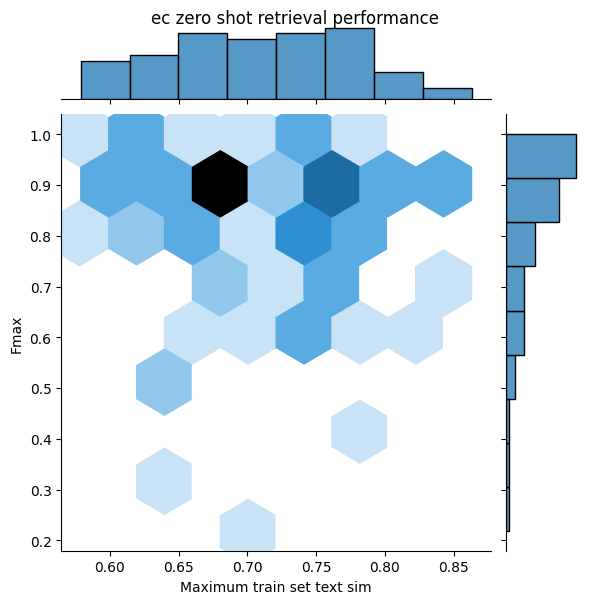

go: got 274 zero shot texts
go: got 274 / 274 zero shot texts have embeddings
go: taking max similarity over 57115 train examples


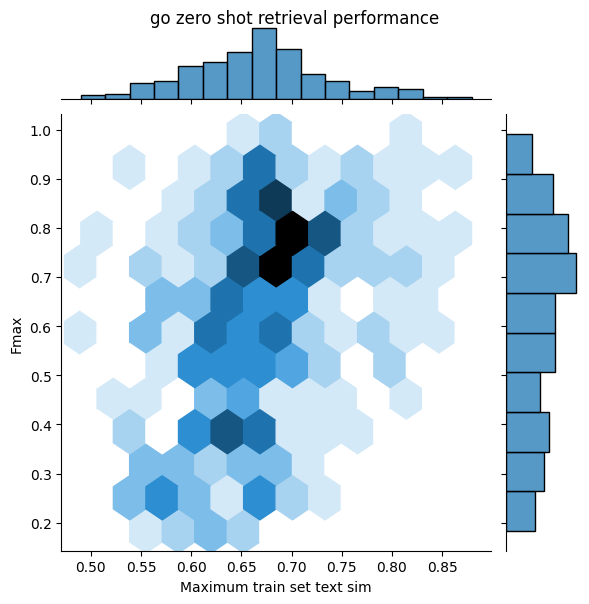

omim: got 1310 zero shot texts
omim: got 5143 / 1310 zero shot texts have embeddings
omim: taking max similarity over 44975 train examples


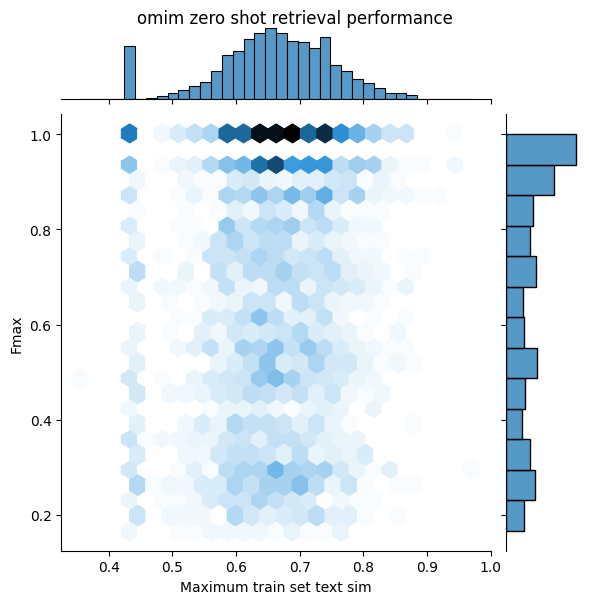

reactome: got 258 zero shot texts
reactome: got 258 / 258 zero shot texts have embeddings
reactome: taking max similarity over 59516 train examples


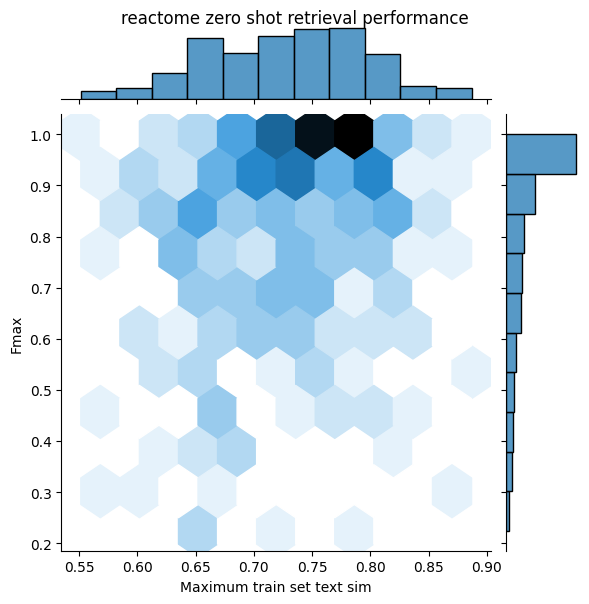

In [21]:
# Create a figure with subplots

for aaseq, dataset in test_datasets:
    if dataset in ["uniprot", "gtop"] or aaseq == "domain":
        continue
    train_set_sims = perf_by_sim_df(aaseq, dataset, cross_database_only=True)
    ax = sns.jointplot(x="max_train_sim", y="Fmax", data=train_set_sims, kind="hex")
    ax.set_axis_labels(xlabel="Maximum train set text sim", ylabel="Fmax")
    ax.figure.suptitle(f"{dataset} zero shot retrieval performance", y=1.0)
    plt.show()

## Dataset similarity

### With separated splits

In [22]:
dataset_sims_path =  data_dir / "dataset_sim_summaries.tsv.gz"
reprocess = False

if reprocess:
    all_summaries = []
    for i, (aaseq_a, dataset_a) in enumerate(all_datasets):
        for j, (aaseq_b, dataset_b) in enumerate(all_datasets[i:]):
            rels_a = (
                load_rels(aaseq_a, dataset_a)
                # Don't really care about val
                .loc[lambda x: ~x.split.str.contains("_val_")]
                .assign(
                    unique_id=lambda x: f"{dataset_a}_" + x.text_id.astype(str),
                )
            )
            rels_b = (
                load_rels(aaseq_b, dataset_b)
                # Don't really care about val
                .loc[lambda x: ~x.split.str.contains("_val_")]
                .assign(
                    unique_id=lambda x: f"{dataset_b}_" + x.text_id.astype(str),
                )
            )
            for x, (split_a, df_a) in enumerate(rels_a.groupby("split")):
                idxs_a = (
                    embed_indices
                    .loc[lambda x: x.unique_id.isin(df_a.drop_duplicates("text_id").unique_id)]
                    .index
                    .to_numpy()
                )

                for y, (split_b, df_b) in enumerate(rels_b.groupby("split")):
                    if dataset_a == dataset_b and x > y:
                        continue

                    idxs_b = (
                        embed_indices
                        .loc[lambda x: x.unique_id.isin(df_b.drop_duplicates("text_id").unique_id)]
                        .index
                        .to_numpy()
                    )
                    print(f"{dataset_a}:{split_a} ({len(idxs_a)}) vs {dataset_b}:{split_b} ({len(idxs_b)})")
                    sims = pd.Series(all_pairwise_sims[idxs_a][:, idxs_b].flatten().numpy()).describe().to_dict()
                    ret = {
                        "dataset_a": dataset_a,
                        "dataset_b": dataset_b,
                        "split_a": split_a,
                        "split_b": split_b,
                    }
                    ret.update(sims)
                    all_summaries.append(ret)
    all_summaries = pd.DataFrame(all_summaries)
    all_summaries.to_csv(dataset_sims_path, sep="\t", index=False)
else:
     all_summaries = pd.read_table(dataset_sims_path)

all_summaries.head()

,dataset_a,dataset_b,split_a,split_b,count,mean,std,min,25%,50%,75%,max
0,go,go,CL_train,CL_train,338724.0,0.310100,0.115356,-0.008488,0.233278,0.292212,0.364402,1.000000
1,go,go,CL_train,eval_five_shot,30846.0,0.315218,0.116220,0.005466,0.237516,0.295220,0.368997,1.000000
2,go,go,CL_train,eval_pt_ft,171108.0,0.311101,0.116121,-0.008488,0.234562,0.293581,0.364857,1.000000
3,go,go,CL_train,eval_zero_shot,40740.0,0.317967,0.101697,0.037990,0.248698,0.306004,0.374029,0.926849
4,go,go,eval_five_shot,eval_five_shot,2809.0,0.410958,0.189052,0.080785,0.265986,0.353832,0.526009,1.000000


In [23]:
def pivot_for_heatmap(df, value_col="mean"):
    """
    Pivots a dataframe into a matrix format suitable for a heatmap.

    Parameters:
    - df: pandas DataFrame containing columns ['dataset_a', 'dataset_b', 'split_a', 'split_b', value_col]
    - value_col: The column to use for heatmap values (e.g., 'mean', 'std', etc.)

    Returns:
    - A pivoted DataFrame with (dataset_a, split_a) as rows and (dataset_b, split_b) as columns.
    """
    df = (
        pd.concat((
            df,
            df.rename(columns={
                "dataset_a": "dataset_b",
                "split_a": "split_b",
                "dataset_b": "dataset_a",
                "split_b": "split_a",
            })
        ))
        .assign(
            row_index=lambda x: x.dataset_a + " | " + x.split_a,
            col_index=lambda x: x.dataset_b + " | " + x.split_b,
        )
        .drop_duplicates(["row_index", "col_index"])
    )

    heatmap_data = df.pivot(index="row_index", columns="col_index", values=value_col)

    return heatmap_data

heatmap_df = pivot_for_heatmap(all_summaries, value_col="mean")
heatmap_df.head()

col_index,disgenet | CL_train,disgenet | eval_two_shot,disgenet | eval_zero_shot,disgenet | eval_zero_shot_easy,drugbank | CL_train,drugbank | eval_pt_ft,drugbank | eval_two_shot,drugbank | eval_zero_shot,drugbank | eval_zero_shot_easy,ec | CL_train,...,omim | eval_zero_shot_easy,pfam | CL_train,pfam | eval_pt_ft,pfam | eval_two_shot,pfam | eval_zero_shot,reactome | CL_train,reactome | eval_pt_ft,reactome | eval_two_shot,reactome | eval_zero_shot,uniprot | CL_train
row_index,,,,,,,,,,,,,,,,,,,,,
disgenet | CL_train,0.293072,0.248562,0.316967,0.188651,0.156542,0.154845,0.138197,0.154229,0.155456,0.180679,...,0.298274,0.191549,0.189818,0.189607,0.192174,0.191912,0.188812,0.184378,0.228047,0.190560
disgenet | eval_two_shot,0.248562,0.318348,0.264852,0.215330,0.150694,0.150629,0.133290,0.145602,0.148239,0.138700,...,0.243642,0.147672,0.147832,0.146548,0.147764,0.153057,0.151553,0.145992,0.176452,0.152515
disgenet | eval_zero_shot,0.316967,0.264852,0.400359,0.207979,0.169707,0.168416,0.149780,0.177452,0.167192,0.221774,...,0.331200,0.219160,0.218888,0.218009,0.219209,0.213442,0.208163,0.204488,0.264674,0.213732
disgenet | eval_zero_shot_easy,0.188651,0.215330,0.207979,0.793065,0.103069,0.103284,0.087664,0.104573,0.101190,0.092371,...,0.195022,0.100155,0.101363,0.097305,0.099484,0.110365,0.109235,0.104705,0.126777,0.104907
drugbank | CL_train,0.156542,0.150694,0.169707,0.103069,0.259520,0.258665,0.246414,0.250130,0.258134,0.187626,...,0.182227,0.171808,0.173252,0.172534,0.170794,0.192412,0.191207,0.192229,0.203493,0.204798


In [24]:
dsets = heatmap_df.index.to_series().str.split("|").str[0].str.strip()
np.where(dsets.ne(dsets.shift()))[0]

array([ 0,  4,  9, 14, 18, 19, 24, 28, 32])

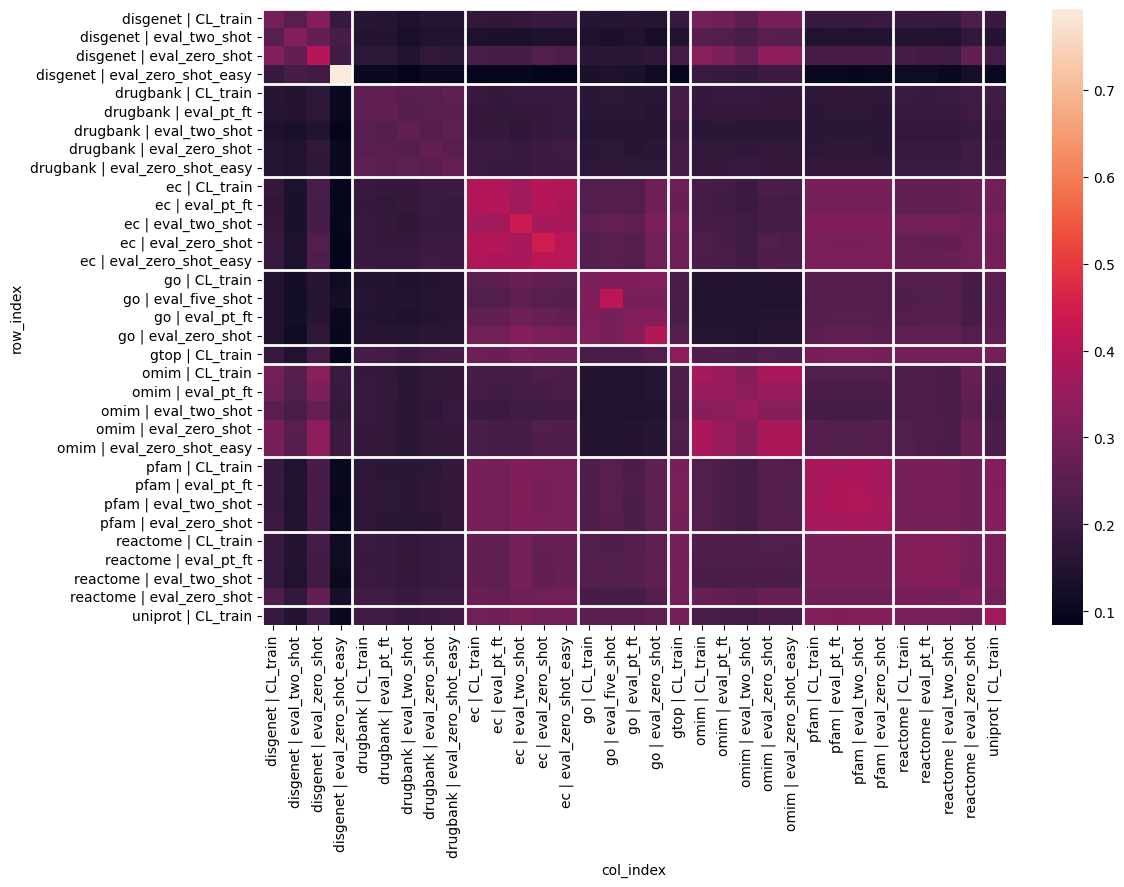

In [25]:
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_df, xticklabels=True, yticklabels=True)

dsets = heatmap_df.index.to_series().str.split("|").str[0].str.strip()
boundaries = np.where(dsets.ne(dsets.shift()))[0]

# Draw horizontal lines to separate different datasets
for r in boundaries:
    ax.hlines(r, *ax.get_xlim(), colors="black", linewidth=2, color="white")

# Draw vertical lines to separate different datasets
for c in boundaries:
        ax.vlines(c, *ax.get_ylim(), colors="black", linewidth=2, color="white")

### No separated splits

In [26]:
dataset_sims_path =  data_dir / "dataset_sim_summaries.no_splits.tsv.gz"

if reprocess:
    all_summaries = []
    for i, (aaseq_a, dataset_a) in enumerate(all_datasets):
        for j, (aaseq_b, dataset_b) in enumerate(all_datasets[i:]):
            rels_a = (
                load_rels(aaseq_a, dataset_a)
                # Don't really care about val
                .loc[lambda x: ~x.split.str.contains("_val_")]
                .assign(
                    unique_id=lambda x: f"{dataset_a}_" + x.text_id.astype(str),
                )
            )
            rels_b = (
                load_rels(aaseq_b, dataset_b)
                # Don't really care about val
                .loc[lambda x: ~x.split.str.contains("_val_")]
                .assign(
                    unique_id=lambda x: f"{dataset_b}_" + x.text_id.astype(str),
                )
            )
            idxs_a = (
                embed_indices
                .loc[lambda x: x.unique_id.isin(rels_a.drop_duplicates("text_id").unique_id)]
                .index
                .to_numpy()
            )


            idxs_b = (
                embed_indices
                .loc[lambda x: x.unique_id.isin(rels_b.drop_duplicates("text_id").unique_id)]
                .index
                .to_numpy()
            )
            print(f"{dataset_a} ({len(idxs_a)}) vs {dataset_b}: ({len(idxs_b)})")
            sims = pd.Series(all_pairwise_sims[idxs_a][:, idxs_b].flatten().numpy()).describe().to_dict()
            ret = {
                "dataset_a": dataset_a,
                "dataset_b": dataset_b,
            }
            ret.update(sims)
            all_summaries.append(ret)
    all_summaries = pd.DataFrame(all_summaries)
    all_summaries.to_csv(dataset_sims_path, sep="\t", index=False)
else:
     all_summaries = pd.read_table(dataset_sims_path)

all_summaries.head()

,dataset_a,dataset_b,count,mean,std,min,25%,50%,75%,max
0,go,go,425104.0,0.312604,0.113966,-0.008488,0.236454,0.295584,0.367566,1.000000
1,go,pfam,7271756.0,0.242975,0.077691,-0.064304,0.188478,0.237568,0.291655,0.863903
2,go,disgenet,4957808.0,0.149497,0.059317,-0.110997,0.108593,0.147321,0.187768,0.724903
3,go,drugbank,3439300.0,0.152556,0.072084,-0.106864,0.101663,0.146732,0.197222,0.781737
4,go,ec,729588.0,0.259681,0.078620,-0.009057,0.204834,0.252183,0.306834,0.756713


In [27]:
def pivot_for_heatmap(df, value_col="mean"):
    """
    Pivots a dataframe into a matrix format suitable for a heatmap.

    Parameters:
    - df: pandas DataFrame containing columns ['dataset_a', 'dataset_b', value_col]
    - value_col: The column to use for heatmap values (e.g., 'mean', 'std', etc.)

    Returns:
    - A pivoted DataFrame with dataset_a as rows and dataset_b as columns.
    """
    df = (
        pd.concat((
            df,
            df.rename(columns={
                "dataset_a": "dataset_b",
                "dataset_b": "dataset_a",
            })
        ))
        .drop_duplicates(["dataset_a", "dataset_b"])
    )

    heatmap_data = df.pivot(index="dataset_a", columns="dataset_b", values=value_col)

    return heatmap_data

heatmap_df = pivot_for_heatmap(all_summaries, value_col="mean")
heatmap_df.head()

dataset_b,disgenet,drugbank,ec,go,gtop,omim,pfam,reactome,uniprot
dataset_a,,,,,,,,,
disgenet,0.294175,0.156530,0.184997,0.159704,0.185724,0.298206,0.192241,0.196260,0.191083
drugbank,0.156530,0.257802,0.191118,0.165652,0.215904,0.181465,0.172110,0.193332,0.204197
ec,0.184997,0.191118,0.396799,0.241945,0.282859,0.224846,0.302432,0.271693,0.291580
go,0.149497,0.152556,0.259681,0.312604,0.222128,0.152248,0.242975,0.237733,0.253524
gtop,0.185724,0.215904,0.282859,0.222128,0.328536,0.232058,0.298888,0.295338,0.293925


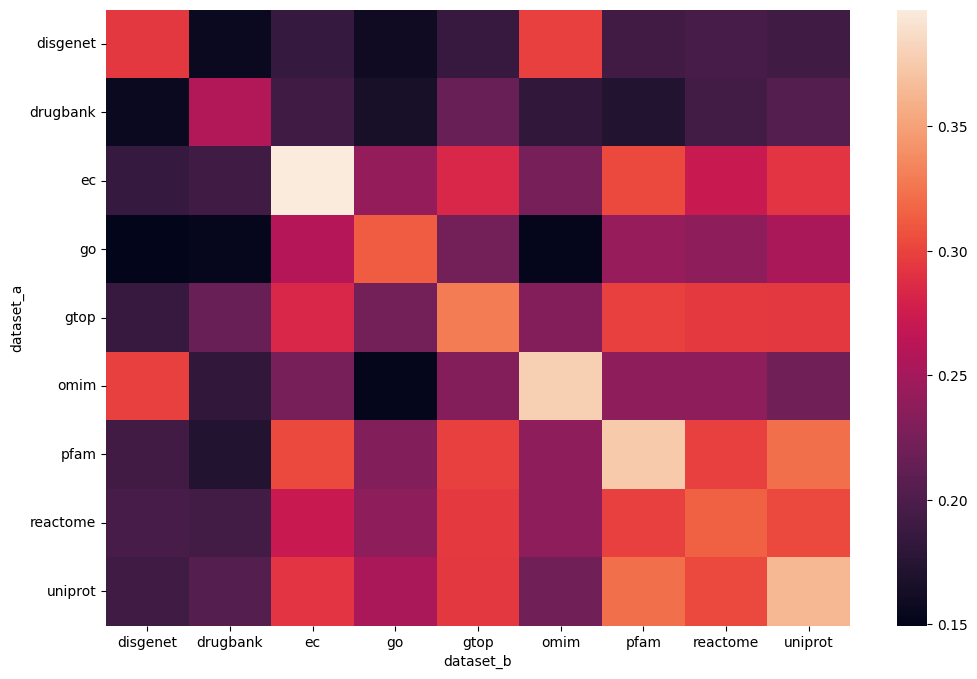

In [28]:
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_df, xticklabels=True, yticklabels=True)
_ = plt.yticks(rotation=0)

<Figure size 1200x800 with 0 Axes>

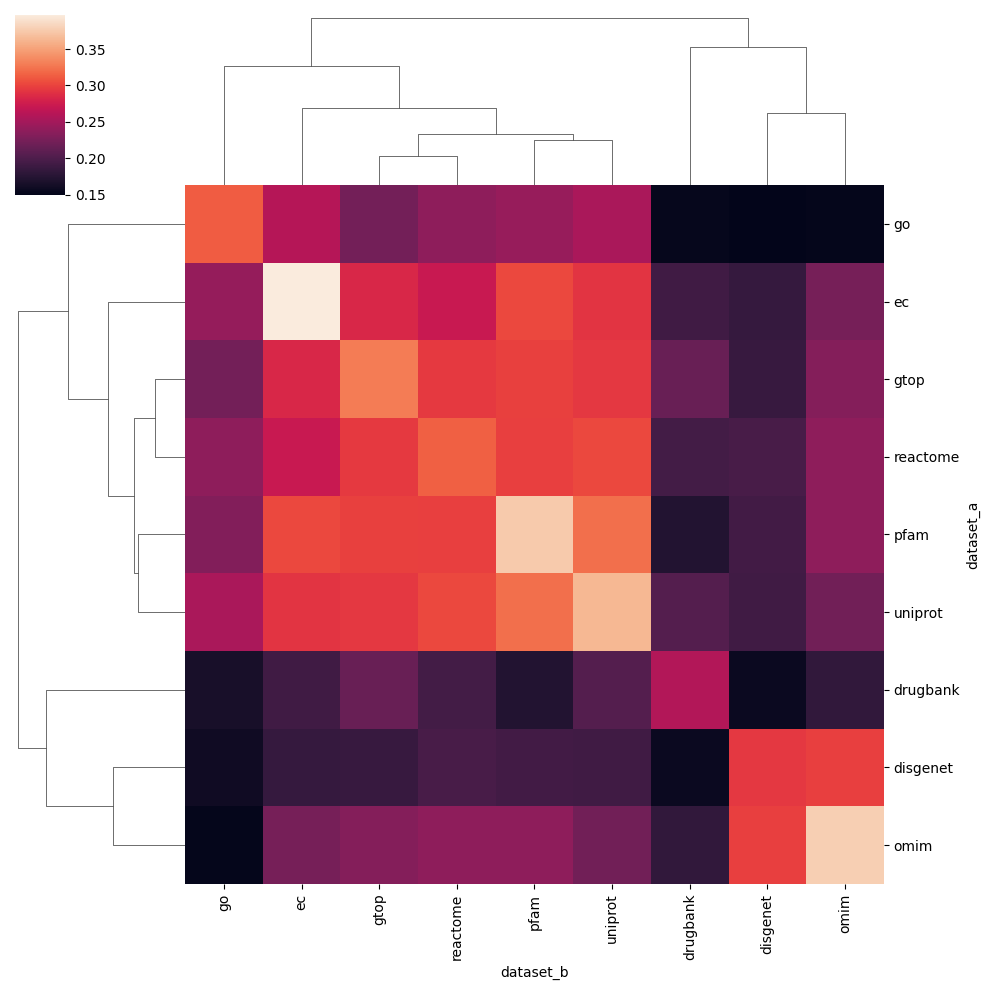

In [29]:
plt.figure(figsize=(12, 8))
ax = sns.clustermap(heatmap_df, xticklabels=True, yticklabels=True)